# Data Challenge : Historical consumption regression for electricity supply pricing
------------------------------
### ElasticNet predictions

## Importings and data preparations

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import calendar
import math
import holidays

# set plotting style
plt.style.use('fivethirtyeight')

#Import training data
inputFilePath = "./input_training_ssnsrY0.csv"
data_train = pd.read_csv(inputFilePath, delimiter = ',', skiprows = 0, index_col=[0])

#Import testing data
inputFilePathTest = "./input_test_cdKcI0e.csv"
data_test = pd.read_csv(inputFilePathTest, delimiter = ',', skiprows = 0, index_col=[0])
id_test = data_test.index

# import targets
outputFilePath = "./output_training_Uf11I9I.csv"
targets = pd.read_csv(outputFilePath, delimiter = ',', skiprows = 0, index_col=[0])

#Remove useless datas
data_train = data_train.drop(["loc_1", "loc_2", "loc_secondary_1", "loc_secondary_2", "loc_secondary_3"], axis = 1)
data_test = data_test.drop(["loc_1", "loc_2", "loc_secondary_1", "loc_secondary_2", "loc_secondary_3"], axis = 1)

data_train.timestamp = pd.to_datetime(data_train.timestamp)
data_test.timestamp = pd.to_datetime(data_test.timestamp)

# create isHoliday feature
fr_holidays = holidays.France()
data_train['isHoliday'] = data_train.timestamp.apply(lambda x:1 if x in fr_holidays else 0)
data_test['isHoliday'] = data_test.timestamp.apply(lambda x:1 if x in fr_holidays else 0)

# indexing with timestamp
data_test = data_test.set_index('timestamp')
data_train = data_train.set_index('timestamp')

# time features
def timefeatures(df):
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['quarter'] = df.index.quarter
    df['weekofyear'] = df.index.weekofyear
    df['dayofweek'] = df.index.dayofweek

    return df

data_train = timefeatures(data_train)
data_test = timefeatures(data_test)

# isWeekend feature
data_train['isWeekend'] = data_train['dayofweek'].apply(lambda x: 1 if x in [5,6] else 0)
data_test['isWeekend'] = data_test['dayofweek'].apply(lambda x: 1 if x in [5,6] else 0)

# smoothing temp and humidity
data_train['temp_1_smooth7D'] = data_train['temp_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)
data_train['temp_2_smooth7D'] = data_train['temp_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)
data_test['temp_1_smooth7D'] = data_test['temp_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)
data_test['temp_2_smooth7D'] = data_test['temp_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round(decimals=1)

data_train['humidity_1_smooth7D'] = data_train['humidity_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()
data_train['humidity_2_smooth7D'] = data_train['humidity_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()
data_test['humidity_1_smooth7D'] = data_test['humidity_1'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()
data_test['humidity_2_smooth7D'] = data_test['humidity_2'].interpolate().rolling(24*7).mean().fillna(method='bfill').round()

# concatenate features and targets
data_train = pd.concat([targets.set_index(data_train.index), data_train],axis=1)

C:\Users\mehdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
figparams = {'figsize':(20,8), 'lw':0.8}

# Create a TimeSeriesSplit object
time_kfold = TimeSeriesSplit(n_splits=3)

--------------------------------------------

# Location 1

## 1-Data and features preparation

In [19]:
# features selection
features_lm_loc1=['hour','isWeekend','weekofyear','month','dayofweek','isHoliday','consumption_secondary_1',
                  'consumption_secondary_2', 'consumption_secondary_3', 'temp_1_smooth7D', 'humidity_1_smooth7D']

# training data
X_train1 = data_train[features_lm_loc1]

# training labels
y_train1 = data_train['consumption_1']

# test data
X_test1 = data_test[features_lm_loc1]

## 2-Grid Search for hyperparameters 

In [21]:
# instantiate a pipeline
steps = [('scaler',StandardScaler()),
        ('ElasticNet',ElasticNet())]

pipeline = Pipeline(steps)

# hyperparameters to tune
parameters = {'ElasticNet__l1_ratio': np.arange(0,1.1,0.1),
             'ElasticNet__alpha':[0.1, 0.4, 0.7, 1, 10]}

# perform grid search
cv_results = GridSearchCV(pipeline, param_grid=parameters, cv=time_kfold,scoring='neg_mean_absolute_error')
cv_results.fit(X_train1, y_train1)

# best score and params
print("best score (neg-MAE): ", cv_results.best_score_)
print('best parameters: ',cv_results.best_params_)

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 961645.0227962132, tolerance: 991.1363352054799
  positive)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1493521.179934355, tolerance: 1814.5044045662096
  positive)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2034502.9110754419, tolerance: 2643.911625205478
  positive)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

best score (neg-MAE):  -15.90963927437321
best parameters:  {'ElasticNet__alpha': 0.4, 'ElasticNet__l1_ratio': 1.0}


## 3-Generating predictions 

Text(0.5, 1.0, 'Predictions for location 1')

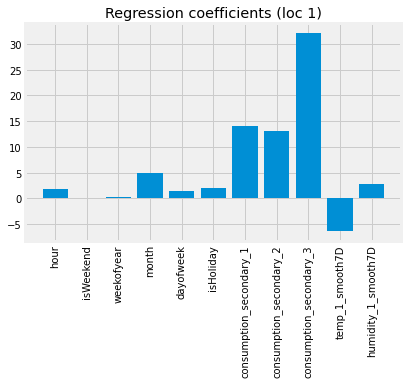

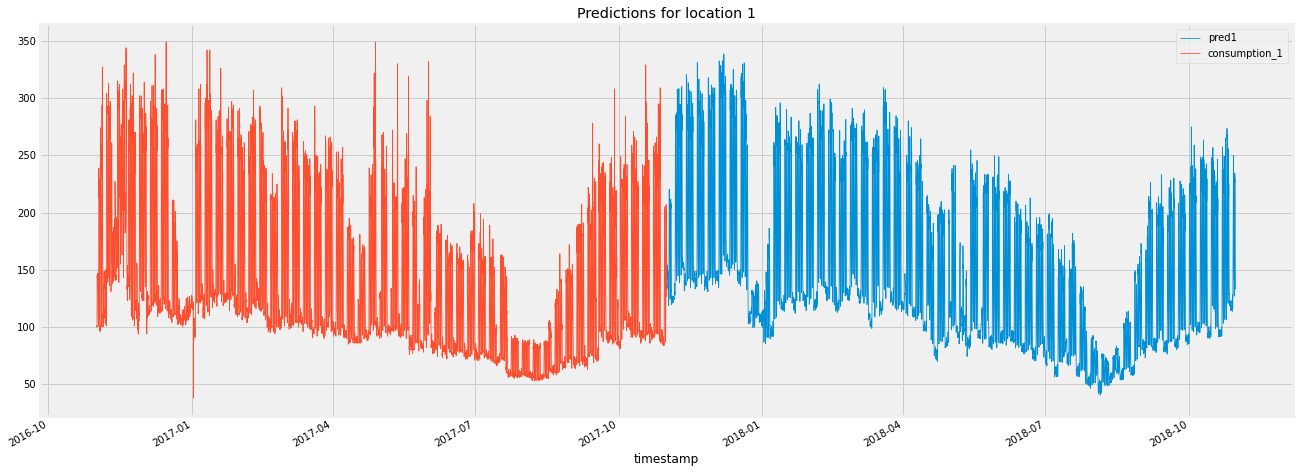

In [34]:
# instantiate pipeline
steps = [('scaler',StandardScaler()),
        ('ElasticNet',ElasticNet(alpha=0.4, l1_ratio=1.0))]
pipeline = Pipeline(steps)

# fit the model and predict
pipeline.fit(X_train1, y_train1)
pred1 = pipeline.predict(X_test1)
pred1_df = pd.DataFrame(pred1, index=data_test.index, columns=['pred1'])

# plotting regression coefficients
plt.bar(features_lm_loc1, pipeline['ElasticNet'].coef_)
plt.xticks(rotation=90)
plt.title('Regression coefficients (loc 1)')

# plotting predictions for location 1
pred1_df.plot(**figparams, legend=True)
y_train1.plot(**figparams, legend=True)
plt.title('Predictions for location 1')

### More plots

<AxesSubplot:xlabel='timestamp'>

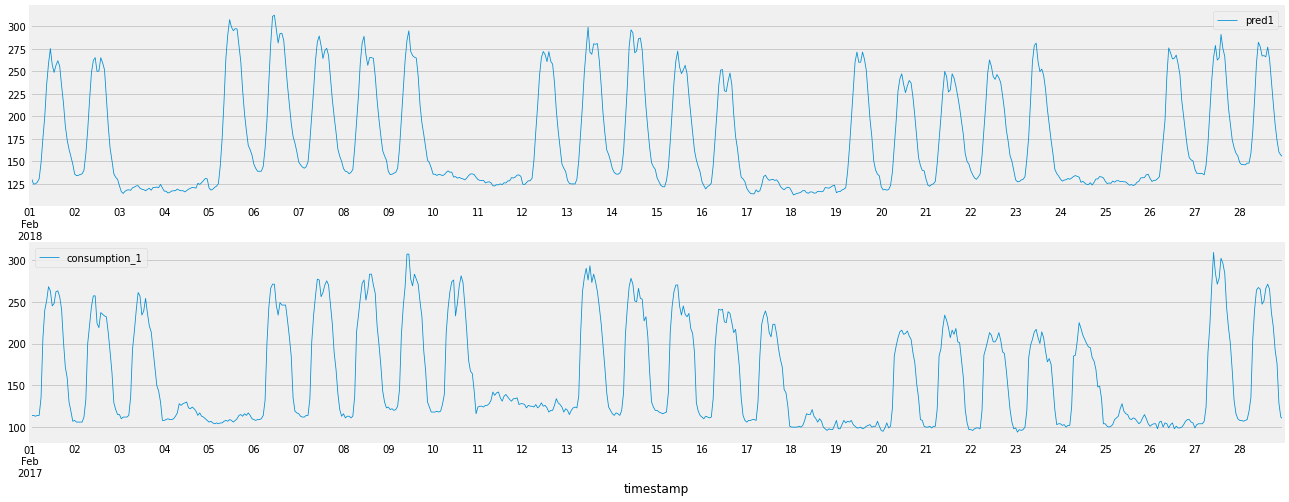

In [35]:
fig,ax=plt.subplots(2,1)
pred1_df.loc['2018-02'].plot(figsize=(20,8), lw=0.8, legend=True, ax=ax[0], sharey=True)
y_train1.loc['2017-02'].plot(figsize=(20,8), lw=0.8, legend=True, ax=ax[1], sharey=True)

------------------


# Location 2

## 1-Data and features preparation

In [28]:
# features selection
features_lm_loc2 =['hour','isWeekend','isHoliday','consumption_secondary_1','consumption_secondary_2','consumption_secondary_3',
                    'temp_2_smooth7D','humidity_2_smooth7D']

# training data
X_train2 = data_train[features_lm_loc2]
# training labels
y_train2 = data_train['consumption_2']

# test data
X_test2 = data_test[features_lm_loc2]

## 2- Grid Search for hyperparamters

In [29]:
# instantiate pipeline
steps = [('scaler',StandardScaler()),
        ('ElasticNet',ElasticNet())]
pipeline = Pipeline(steps)

# hyperparameters to tune
parameters = {'ElasticNet__l1_ratio': np.arange(0,1.1,0.1),
             'ElasticNet__alpha':[0.1, 0.5, 0.9, 1, 5, 10]}

# perform grid search
cv_results = GridSearchCV(pipeline, param_grid=parameters, cv=time_kfold,scoring='neg_mean_absolute_error')
cv_results.fit(X_train2, y_train2)

# print best score and params
print("best score(neg-MAE): ", cv_results.best_score_)
print('best params: ',cv_results.best_params_)

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1997984.7559409412, tolerance: 1802.8100449315075
  positive)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3090295.5620844527, tolerance: 2651.081613949772
  positive)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4472544.243232263, tolerance: 3666.130355190259
  positive)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

best score(neg-MAE):  -24.338192932962134
best params:  {'ElasticNet__alpha': 0.9, 'ElasticNet__l1_ratio': 0.0}


C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9384983.148812963, tolerance: 4701.489216392695
  positive)


## 3-Generating predictions

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9384983.148812963, tolerance: 4701.489216392695
  positive)


Text(0.5, 1.0, 'Prediction for location 2')

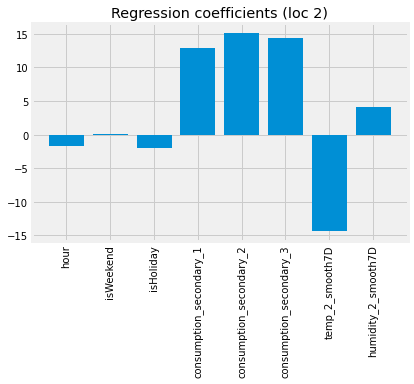

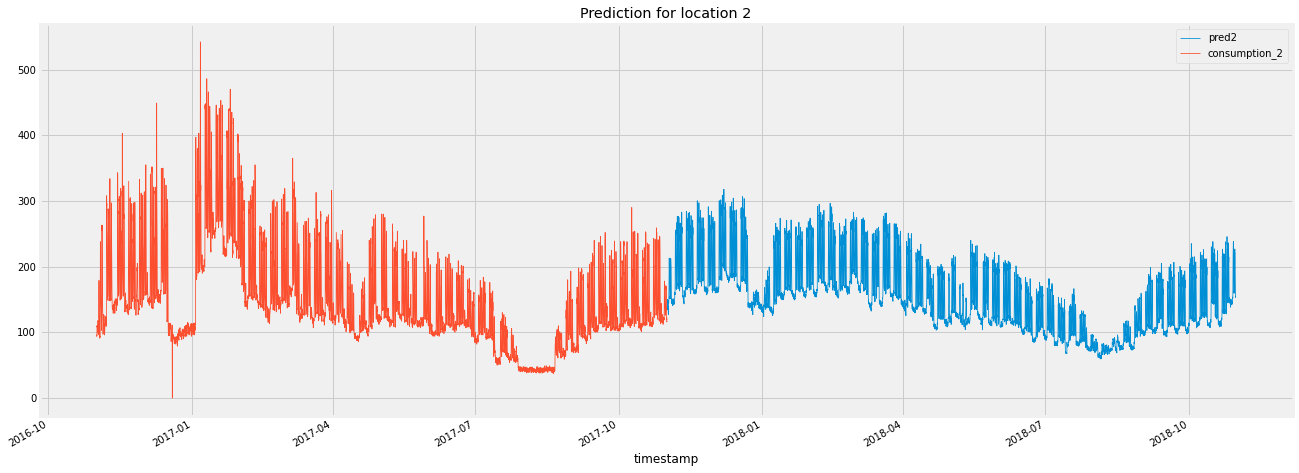

In [36]:
# instantiate pipeline
steps = [('scaler',StandardScaler()),
        ('ElasticNet',ElasticNet(alpha=0.9, l1_ratio=0.0))]
pipeline = Pipeline(steps)

# fit the model and predict
pipeline.fit(X_train2, y_train2)
pred2 = pipeline.predict(X_test2)
pred2_df = pd.DataFrame(pred2, index=data_test.index, columns=['pred2'])

# plotting regression coefficients
plt.bar(features_lm_loc2, pipeline['ElasticNet'].coef_)
plt.xticks(rotation=90)
plt.title('Regression coefficients (loc 2)')

# plotting predictions for location 2
pred2_df.plot(**figparams, legend=True)
y_train2.plot(**figparams, legend=True)
plt.title('Prediction for location 2')

### More plots

<AxesSubplot:xlabel='timestamp'>

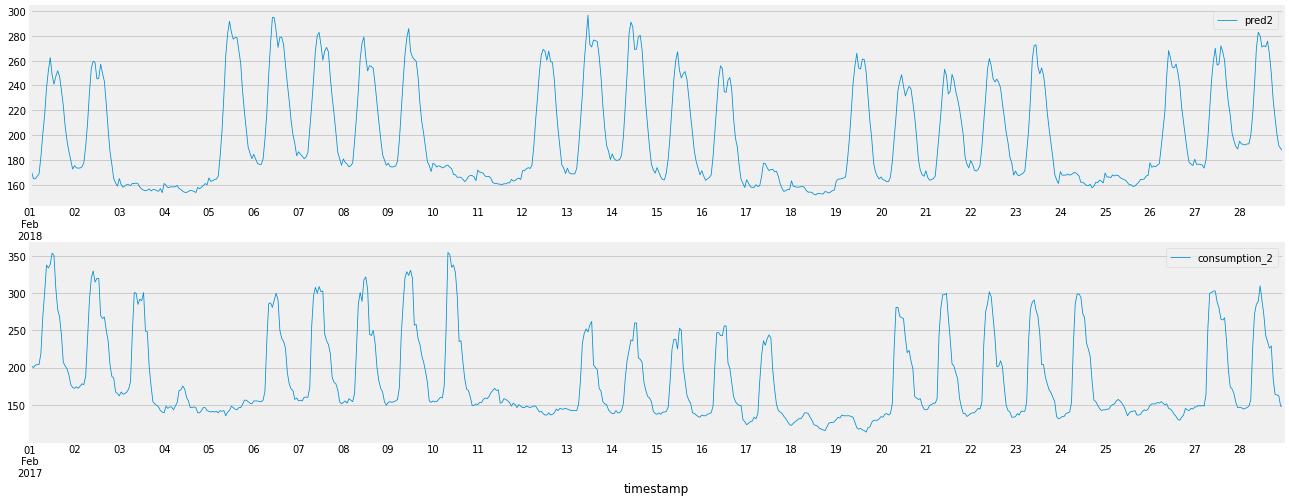

In [37]:
fig,ax=plt.subplots(2,1)
pred2_df.loc['2018-02'].plot(figsize=(20,8), lw=0.8, legend=True, ax=ax[0], sharey=True)
y_train2.loc['2017-02'].plot(figsize=(20,8), lw=0.8, legend=True, ax=ax[1], sharey=True)

# Submission

In [38]:
sub = pd.concat([pred1_df.round(1),pred2_df.round(1)], axis=1).set_index(id_test)
sub.to_csv('submission_elanet_verif.csv') 